## Rao-Blackwellized MCMC Sampling Pseudo-code

1. Initialize counts for all `y_k` and edge pairs `(P_k-1,k and P_k,k+1)` to zero.

2. **For** each sample in MCMC iterations:
    1. **For** each position `k` in the sequence:
        - Sample `y_k` from the distribution given other y's `(p(y_k | y_1, ..., y_k-1, y_k+1, ...))`.
        - Increment the count for `y_k` based on the sampled value with its probability.
        - **If** `k` > 1:
            - Increment the count for `P_k-1,k` with the probability of `y_k` given `y_k-1`.
        - **If** `k` < length of the sequence:
            - Increment the count for `P_k,k+1` with the probability of `y_k` given `y_k+1`.
            
3. After all samples are drawn:
    - Normalize the counts to estimate probabilities.

4. **Return** the estimated marginal and edge distributions.


In [47]:
import numpy as np
import os

import os

# Base path where your data resides, relative to your code directory
base_data_path = os.path.join("..", "data")

# Define file names
decode_input_file = "decode_input.txt"
train_struct_file = "train_struct.txt"
model_file = "model.txt"
train_data_file = "train.txt"
test_data_file = "test.txt"
parameter_file = "Parameters"

# Build full paths by appending file names to the base data path
decode_input_path = os.path.join(base_data_path, decode_input_file)
train_struct_path = os.path.join(base_data_path, train_struct_file)
model_path = os.path.join(base_data_path, model_file)
train_data_path = os.path.join(base_data_path, train_data_file)
test_data_path = os.path.join(base_data_path, test_data_file)
parameter_path = os.path.join("..", "results", parameter_file)

# Now you can use these paths in your code
print("File paths:")
print("Decode input path:", decode_input_path)
print("Train struct path:", train_struct_path)
print("Model path:", model_path)
print("Train data path:", train_data_path)
print("Test data path:", test_data_path)



def read_decode_input(file_path = decode_input_path):
    """
    Reads the decode_input data from the file.
    Each line represents one letter with 128 elements.
    There are 26 weight vectors each with 128 elements and a transition matrix T with size 26x26.
    The transition matrix T is in row-major order.
    """
    with open(file_path, "r") as f:
        raw_data = f.read().split("\n")

    X = np.array(raw_data[:100 * 128], dtype=float).reshape(100, 128)
    W = np.array(raw_data[100 * 128:100 * 128 + 26 * 128], dtype=float).reshape(26, 128)
    T = np.array(raw_data[100 * 128 + 26 * 128:-1], dtype=float).reshape(26, 26)
    T = np.swapaxes(T, 0, 1)
    
    print("Shapes of decode input:")
    print("X:", X.shape, "W:", W.shape, "T:", T.shape)
    #print("Top 5 rows of X:\n", X[:5])

    return X, W, T

def read_train_struct(file_path = train_struct_path):
    """
    Reads the train_struct data from the file.
    Each line represents a label and a feature vector (in a sparse representation).
    """
    with open(file_path, "r") as f:
        raw_data = f.read().split("\n")

    dataX, dataY = [], []
    for line in raw_data[:-1]:  # The last element is empty
        line = line.split(" ")
        dataY.append([int(line[0]) - 1, int(line[1][4:])])
        datax = np.zeros(128, dtype=int)
        for f1 in line[2:]:
            idx, val = f1.split(":")
            datax[int(idx) - 1] = int(val)
        dataX.append(datax)
    
    dataX_np = np.array(dataX, dtype=int)
    print("Shapes of train_struct:")
    print("dataX:", dataX_np.shape, "dataY length:", len(dataY))
    #print("Top 5 rows of dataX:\n", dataX_np[:5])
    
    return dataX_np, dataY

def read_model(file_path = model_path):
    """
    Reads the model data from the file.
    The data consists of weight vectors for each label and a transition matrix T.
    """
    with open(file_path, "r") as f:
        raw_data = f.read().split("\n")

    W = np.array(raw_data[:26 * 128], dtype=float).reshape(26, 128)
    T = np.array(raw_data[26 * 128:-1], dtype=float).reshape(26, 26)
    T = np.swapaxes(T, 0, 1)
    
    print("Shapes of model data:")
    print("W:", W.shape, "T:", T.shape)
    #print("Top 5 rows of W:\n", W[:5])
    
    return W, T

def read_train(file_path = train_data_path):
    """
    Reads the train data from the file.
    Each row corresponds to an example and is split into the label and the feature vector.
    """
    from string import ascii_lowercase
    mapping = {letter: idx for idx, letter in enumerate(ascii_lowercase)}

    with open(file_path, "r") as f:
        raw_data = f.read().split("\n")

    dataX, dataY = [], []
    tempX, tempY = [], []
    for row in raw_data[:-1]:
        row = row.split(" ")
        tempY.append(mapping[row[1]])
        tempX.append(np.array(row[5:], dtype=float))
        if int(row[2]) < 0:  # End of sequence
            dataX.append(np.array(tempX))
            dataY.append(np.array(tempY, dtype=int))
            tempX, tempY = [], []  # Reset for the next sequence

    print("Number of training sequences:", len(dataX))
    print("First 5 sequences' labels:\n", dataY[:5])
    
    return list(zip(dataX, dataY))

import numpy as np

def read_test(file_path = test_data_path):
    """
    Reads the test data from the file.
    Each row corresponds to an example and is split into the label and the feature vector.
    The function assumes that each example ends when a row with the third column less than 0 is encountered.
    """
    from string import ascii_lowercase
    mapping = {letter: idx for idx, letter in enumerate(ascii_lowercase)}

    with open(file_path, "r") as f:
        raw_data = f.read().split("\n")

    dataX, dataY = [], []
    tempX, tempY = [], []
    for row in raw_data[:-1]:  # Skip the last empty line if it exists
        row = row.split(" ")
        tempY.append(mapping[row[1]])
        tempX.append(np.array(row[5:], dtype=float))
        if int(row[2]) < 0:  # Check for the end of a sequence
            dataX.append(np.array(tempX))
            dataY.append(np.array(tempY, dtype=int))
            tempX, tempY = [], []  # Reset for the next sequence

    print("Number of test sequences:", len(dataX))
    print("First 5 sequences' labels:\n", dataY[:5])

    return list(zip(dataX, dataY))

def read_test_decoder_modified(file_path = test_data_path):
    """
    Reads the test data for decoding and returns a NumPy array
    where each sub-array from the list becomes a row in the final
    two-dimensional array. This function only extracts the features
    and does not deal with the labels.
    """
    with open(file_path, 'r') as file:
        raw_data = file.read().strip().split('\n')

    # Initialize an empty list to store all feature vectors
    dataX = []
    
    for row in raw_data:
        if row:  # Skip any empty lines
            features = row.split(' ')[5:]  # Features start from the 6th element in the row
            feature_vector = list(map(float, features))  # Convert string features to float
            dataX.append(feature_vector)

    # Convert the list of lists (features for each word) into a 2D NumPy array
    dataX_np = np.array(dataX)

    print("Shape of test data for decoder:", dataX_np.shape)
    print("Top 5 feature vectors:\n", dataX_np[:5, :])

    return dataX_np

File paths:
Decode input path: ..\data\decode_input.txt
Train struct path: ..\data\train_struct.txt
Model path: ..\data\model.txt
Train data path: ..\data\train.txt
Test data path: ..\data\test.txt


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
from scipy.special import logsumexp
# Assuming you have functions to perform MCMC sampling and compute Rao-Blackwellized estimates

# Load your model and training data
model = read_model()  # Function to read model from model.txt
first_word = read_train()[0][0]  # Reads first sequence from train.txt

def sample_given_neighbors(k, T, W, y):
    """
    Sample a value for y[k] given its neighbors and the current state of the sequence.
    
    :param k: Index of the node in the sequence to sample
    :param T: Transition matrix
    :param W: Weight matrix
    :param y: Current state of the sequence
    :return: Sampled value for y[k]
    """
    # Assuming y[k] can take on values from 0 to |Y|-1
    num_classes = T.shape[0]
    probs = np.zeros(num_classes)
    
    # Calculate the conditional probability for each class
    for c in range(num_classes):
        prob = np.exp(W[c] @ X[k])  # Potential based on node features
        
        # Include transitions from previous and next nodes if they exist
        if k > 0:  # If not the first node
            prob *= T[y[k-1], c]
        if k < len(y) - 1:  # If not the last node
            prob *= T[c, y[k+1]]
            
        probs[c] = prob
    
    # Normalize to get a probability distribution
    probs /= np.sum(probs)
    
    # Sample from the distribution
    return np.random.choice(num_classes, p=probs)

def conditional_probability(k, T, W, y, X):
    """
    Compute the conditional probability distribution p(y[k] | neighbors, X) for all possible values of y[k].
    
    :param k: Index of the node in the sequence
    :param T: Transition matrix
    :param W: Weight matrix
    :param y: Current state of the sequence
    :param X: Feature matrix for the sequence
    :return: Conditional probability distribution for y[k]
    """
    num_classes = T.shape[0]
    probs = np.zeros(num_classes)
    
    for c in range(num_classes):
        prob = np.exp(W[c] @ X[k])  # Potential based on node features
        
        if k > 0:
            prob *= T[y[k-1], c]
        if k < len(y) - 1:
            prob *= T[c, y[k+1]]
            
        probs[c] = prob
    
    probs /= np.sum(probs)
    return probs


Shapes of model data:
W: (26, 128) T: (26, 26)
Number of training sequences: 3438
First 5 sequences' labels:
 [array([ 0, 10,  4]), array([14, 12, 12,  0, 13,  3,  8, 13,  6]), array([ 4, 17, 14]), array([13,  4, 23, 15,  4,  2, 19,  4,  3]), array([ 4,  2, 11,  0, 17,  8, 13,  6])]


In [49]:
# Assume that these are the functions you have for loading the data
# They should return the appropriate data structures needed for the MCMC sampling
model = read_model()  # W, T from the model.txt
first_word, first_word_labels = read_train()[0]  # X, y from the first sequence in train.txt

def sample_given_neighbors(k, T, W, y, X):
    num_classes = T.shape[0]
    probs = np.zeros(num_classes)
    
    # Assuming X[k] is the feature vector for the k-th node in the sequence
    # Calculate the conditional probability for each class
    for c in range(num_classes):
        prob = np.exp(W[c] @ X[k])  # Log-linear model for node features
        
        # Include transitions from previous and next nodes if they exist
        if k > 0:  # If not the first node
            prob *= np.exp(T[y[k-1], c])
        if k < len(y) - 1:  # If not the last node
            prob *= np.exp(T[c, y[k+1]])
            
        probs[c] = prob
    
    # Normalize to get a probability distribution
    probs = np.maximum(probs, 0)  # Ensure non-negative
    probs /= np.sum(probs)
    
    # Sample from the distribution
    return np.random.choice(num_classes, p=probs)

def rao_blackwellized_mcmc(X, T, W, S, num_classes):
    num_nodes = len(X)
    marginal_counts = np.zeros((num_nodes, num_classes))
    edge_counts = np.zeros((num_nodes - 1, num_classes, num_classes))
    
    # Initialize the sequence randomly
    y = np.random.choice(num_classes, num_nodes)

    for _ in range(S):
        for k in range(num_nodes):
            y[k] = sample_given_neighbors(k, T, W, y, X)

        for k in range(num_nodes):
            probs = conditional_probability(k, T, W, y, X)
            marginal_counts[k] += probs * (1 / S)  # Rao-Blackwellization step
            
            if k > 0:
                edge_probs = np.outer(probs, conditional_probability(k - 1, T, W, y, X))
                edge_counts[k - 1] += edge_probs * (1 / S)  # Rao-Blackwellization step for edges

    # Since we're accumulating fractional counts, no need to normalize again
    estimated_marginals = marginal_counts
    estimated_edges = edge_counts

    return estimated_marginals, estimated_edges



def softmax(x):
    """Compute softmax values for each set of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def kl_divergence(p, q):
    """
    Calculate the Kullback-Leibler divergence between two distributions.
    Ensure the distributions are normalized and contain no zeros.
    """
    p = np.maximum(p, 1e-10)  # replace 0 with a small value to avoid log(0)
    q = np.maximum(q, 1e-10)
    return np.sum(p * np.log(p / q))



Shapes of model data:
W: (26, 128) T: (26, 26)
Number of training sequences: 3438
First 5 sequences' labels:
 [array([ 0, 10,  4]), array([14, 12, 12,  0, 13,  3,  8, 13,  6]), array([ 4, 17, 14]), array([13,  4, 23, 15,  4,  2, 19,  4,  3]), array([ 4,  2, 11,  0, 17,  8, 13,  6])]


In [50]:
# We'll use the first sequence's feature matrix (X) and labels (y_true)
X, y_true = train_sequences[0]

# Number of classes and samples for MCMC
num_classes = 26
S = 10

# Run the Rao-Blackwellized MCMC
estimated_marginals, estimated_edges = rao_blackwellized_mcmc(X, T, W, S, num_classes)


In [51]:
np.shape(estimated_marginals)

print("estimated_marginals shape: ",np.shape(estimated_marginals))
print("estimated_edges shape: ",np.shape(estimated_edges))

estimated_marginals shape:  (3, 26)
estimated_edges shape:  (2, 26, 26)


In [59]:
estimated_marginals

array([[ 9.63944636e-03,  4.12537646e-02, -1.58015448e-02,
        -1.32258484e-03, -2.97751538e-04,  1.71875496e-02,
         2.48542432e-03, -4.57096688e-05,  1.15366855e-03,
        -1.07194382e-02, -5.89050489e-04,  2.04566907e-04,
         3.60930196e-03,  2.16783853e-02,  1.42353790e-03,
        -3.60904742e-02,  5.80614382e-01,  3.43952106e-02,
         2.55904210e-02,  1.13466875e-02,  6.99616260e-03,
         1.94339437e-02,  6.44246530e-03,  7.83664965e-03,
         2.10244707e-02,  2.52550515e-01],
       [-1.74769652e-02,  7.75880370e-03, -2.20959037e-03,
        -9.86401566e-02,  7.52649470e-04,  2.10847684e-01,
        -2.94870139e-04, -6.68817397e-03,  5.14755984e-01,
         1.72642542e-02,  2.75877703e-02,  2.66901845e-03,
         4.29861333e-03,  1.84928863e-01,  4.17103173e-02,
        -1.31634583e-01,  5.70216497e-02,  1.35148667e-01,
        -6.09190451e-02,  1.26496529e-02, -7.86942379e-03,
         1.52640314e-03,  7.37929471e-02,  6.25052665e-03,
         2.53

In [53]:
def forward_pass(X, T, W):
    """
    Perform the forward pass to compute alpha values.
    :param X: Observations/features for a sequence
    :param T: Transition matrix
    :param W: Weight matrix
    :return: Alpha values
    """
    num_nodes, num_classes = len(X), T.shape[0]
    alpha = np.zeros((num_nodes, num_classes))
    
    # Initialization
    alpha[0] = np.exp(W @ X[0])  # Assuming W @ X gives log potentials for all classes
    alpha[0] /= np.sum(alpha[0])  # Normalize
    
    # Induction
    for k in range(1, num_nodes):
        for y_next in range(num_classes):
            alpha[k, y_next] = np.sum(alpha[k-1] * T[:, y_next] * np.exp(W @ X[k]))
        alpha[k] /= np.sum(alpha[k])  # Normalize
    
    return alpha

def backward_pass(X, T, W):
    """
    Perform the backward pass to compute beta values.
    :param X: Observations/features for a sequence
    :param T: Transition matrix
    :param W: Weight matrix
    :return: Beta values
    """
    num_nodes, num_classes = len(X), T.shape[0]
    beta = np.zeros((num_nodes, num_classes))
    
    # Initialization
    beta[-1] = np.ones(num_classes)  # All ones for the last node
    
    # Induction
    for k in range(num_nodes - 2, -1, -1):
        for y_prev in range(num_classes):
            beta[k, y_prev] = np.sum(beta[k+1] * T[y_prev, :] * np.exp(W @ X[k+1]))
        beta[k] /= np.sum(beta[k])  # Normalize
    
    return beta

def compute_marginals(alpha, beta, X, T, W):
    """
    Compute the node and edge marginal distributions using alpha and beta values.
    :param alpha: Alpha values from the forward pass
    :param beta: Beta values from the backward pass
    :param X: Observations/features for a sequence
    :param T: Transition matrix
    :param W: Weight matrix
    :return: Node and edge marginal distributions
    """
    num_nodes, num_classes = alpha.shape
    p_node = np.zeros((num_nodes, num_classes))
    p_edge = np.zeros((num_nodes - 1, num_classes, num_classes))
    
    # Compute node marginals
    for k in range(num_nodes):
        p_node[k] = alpha[k] * beta[k]
        p_node[k] /= np.sum(p_node[k])  # Normalize
    
    # Compute edge marginals
    for k in range(1, num_nodes):
        for y_prev in range(num_classes):
            for y_next in range(num_classes):
                observation_potential = np.exp(W[y_next] @ X[k])
                p_edge[k-1, y_prev, y_next] = alpha[k-1, y_prev] * T[y_prev, y_next] * observation_potential * beta[k, y_next]
        p_edge[k-1] /= np.sum(p_edge[k-1])  # Normalize
    
    return p_node, p_edge



In [54]:
X, W, T = read_decode_input()

Shapes of decode input:
X: (100, 128) W: (26, 128) T: (26, 26)


In [55]:
# Assuming X, T, and W have been obtained as described
X, W, T = read_decode_input()

# Perform forward and backward passes
alpha = forward_pass(X, T, W)
beta = backward_pass(X, T, W)

# Compute the true node and edge marginal distributions
p_node_true, p_edge_true = compute_marginals(alpha, beta, X, T, W)

print("Shapes of p_node_true and p_edge_true:", p_node_true.shape, p_edge_true.shape)


Shapes of decode input:
X: (100, 128) W: (26, 128) T: (26, 26)
Shapes of p_node_true and p_edge_true: (100, 26) (99, 26, 26)


In [60]:
np.shape(p_node_true)

print("p_node_true shape: ",np.shape(p_node_true))
print("p_edge_true shape: ",np.shape(p_edge_true))

p_node_true

p_node_true shape:  (100, 26)
p_edge_true shape:  (99, 26, 26)


array([[-2.02053433e-02,  4.10414013e-02, -2.86585748e-03, ...,
         7.60239144e-02, -4.74643040e-02, -1.67155399e-03],
       [ 2.36440093e-01, -3.97489069e+00, -1.06445373e+00, ...,
         1.61929624e-02,  3.11548171e-01,  5.10703068e+00],
       [ 8.58076110e-02,  7.10555405e-01,  5.04762622e-02, ...,
        -2.30290942e-03,  4.97984269e-01,  9.80255175e-01],
       ...,
       [ 5.54386611e-02, -2.49502118e-01,  6.13292626e-02, ...,
        -3.78753760e-02,  1.89728005e-02,  3.31144486e-03],
       [-1.14009022e+00,  1.65786912e+00,  9.56199106e-02, ...,
        -2.21004193e-01,  4.82380340e-01,  8.61878036e-01],
       [-2.06353520e-01,  3.24919569e-01, -9.51931372e-01, ...,
         5.26258059e-01,  5.61823023e-01,  1.19795964e-02]])

In [66]:
import numpy as np
import matplotlib.pyplot as plt

def kl_divergence(p, q):
    """
    Compute the KL divergence between two probability distributions.
    Avoid division by zero by ensuring q is positive and log argument is never zero.
    """
    epsilon = np.finfo(float).eps
    q = np.maximum(q, epsilon)  # Ensure q is positive
    ratio = np.where(p != 0, p / q, 0)  # Avoid division by zero in ratio
    ratio = np.maximum(ratio, epsilon)  # Ensure ratio is never zero before taking log
    return np.sum(np.where(p != 0, p * np.log(ratio), 0))


# Assuming S is defined elsewhere as the number of samples
S = 100

# Use the actual dynamic programming results
p_node_true_mean = p_node_true.mean(axis=0)  # Average over nodes for true node marginals
p_edge_true_mean = p_edge_true.reshape(-1, num_classes*num_classes).mean(axis=0)  # Average and flatten for true edge marginals

# Initialize lists to hold cumulative KL-divergences
kl_node_rb = []
kl_edge_rb = []
kl_node = []
kl_edge = []

for s in range(1, S + 1):
    # Rao-Blackwellized MCMC estimates
    estimated_marginals_rb, estimated_edges_rb = rao_blackwellized_mcmc(X, T, W, s, num_classes)
    
    # Debug: Check shapes and values
    print(f"Shape of estimated_marginals_rb_mean: {estimated_marginals_rb.shape}")
    print(f"Shape of estimated_edges_rb_mean: {estimated_edges_rb.shape}")
    
    # Average and flatten Rao-Blackwellized MCMC estimates for comparison
    estimated_marginals_rb_mean = estimated_marginals_rb.mean(axis=0)  # Average over nodes
    estimated_edges_rb_mean = estimated_edges_rb.reshape(-1, num_classes*num_classes).mean(axis=0)  # Average and flatten
    
    # Debug: Check if distributions sum up to 1
    print(f"Sum of estimated_marginals_rb_mean: {estimated_marginals_rb_mean.sum()}")
    print(f"Sum of estimated_edges_rb_mean: {estimated_edges_rb_mean.sum()}")
    
    # Compute cumulative KL divergence for node marginals and edge marginals
    kl_node_rb.append(kl_divergence(p_node_true_mean, estimated_marginals_rb_mean))
    kl_edge_rb.append(kl_divergence(p_edge_true_mean, estimated_edges_rb_mean))
    print(f"Sample {s}: Node RB KL = {kl_node_rb[-1]}, Edge RB KL = {kl_edge_rb[-1]}")


Shape of estimated_marginals_rb_mean: (100, 26)
Shape of estimated_edges_rb_mean: (99, 26, 26)
Sum of estimated_marginals_rb_mean: 0.9999999999999988
Sum of estimated_edges_rb_mean: 0.9999999999999649
Sample 1: Node RB KL = 42.08786855054019, Edge RB KL = 223.29999492985638
Shape of estimated_marginals_rb_mean: (100, 26)
Shape of estimated_edges_rb_mean: (99, 26, 26)
Sum of estimated_marginals_rb_mean: 1.0000000000000016
Sum of estimated_edges_rb_mean: 1.0000000000000004
Sample 2: Node RB KL = 34.32432924651215, Edge RB KL = 214.1728330000213
Shape of estimated_marginals_rb_mean: (100, 26)
Shape of estimated_edges_rb_mean: (99, 26, 26)
Sum of estimated_marginals_rb_mean: 1.0000000000000009
Sum of estimated_edges_rb_mean: 0.9999999999999925
Sample 3: Node RB KL = 37.27305473778639, Edge RB KL = 222.29919721102777
Shape of estimated_marginals_rb_mean: (100, 26)
Shape of estimated_edges_rb_mean: (99, 26, 26)
Sum of estimated_marginals_rb_mean: 1.0
Sum of estimated_edges_rb_mean: 0.9999999

Shape of estimated_marginals_rb_mean: (100, 26)
Shape of estimated_edges_rb_mean: (99, 26, 26)
Sum of estimated_marginals_rb_mean: 1.0
Sum of estimated_edges_rb_mean: 0.9999999999999988
Sample 32: Node RB KL = 44.12995393020681, Edge RB KL = 229.08646277191846
Shape of estimated_marginals_rb_mean: (100, 26)
Shape of estimated_edges_rb_mean: (99, 26, 26)
Sum of estimated_marginals_rb_mean: 1.0000000000000009
Sum of estimated_edges_rb_mean: 1.0
Sample 33: Node RB KL = 45.97166167145368, Edge RB KL = 212.88045082184192
Shape of estimated_marginals_rb_mean: (100, 26)
Shape of estimated_edges_rb_mean: (99, 26, 26)
Sum of estimated_marginals_rb_mean: 0.9999999999999997
Sum of estimated_edges_rb_mean: 1.0000000000000284
Sample 34: Node RB KL = 38.88009172248834, Edge RB KL = 208.62211873781393
Shape of estimated_marginals_rb_mean: (100, 26)
Shape of estimated_edges_rb_mean: (99, 26, 26)
Sum of estimated_marginals_rb_mean: 0.9999999999999996
Sum of estimated_edges_rb_mean: 1.0000000000000242
S

Shape of estimated_marginals_rb_mean: (100, 26)
Shape of estimated_edges_rb_mean: (99, 26, 26)
Sum of estimated_marginals_rb_mean: 0.9999999999999998
Sum of estimated_edges_rb_mean: 1.0000000000000098
Sample 63: Node RB KL = 50.81682856516901, Edge RB KL = 222.8576334168824
Shape of estimated_marginals_rb_mean: (100, 26)
Shape of estimated_edges_rb_mean: (99, 26, 26)
Sum of estimated_marginals_rb_mean: 1.0000000000000002
Sum of estimated_edges_rb_mean: 1.0000000000000042
Sample 64: Node RB KL = 22.839034419519102, Edge RB KL = 227.8864832438283
Shape of estimated_marginals_rb_mean: (100, 26)
Shape of estimated_edges_rb_mean: (99, 26, 26)
Sum of estimated_marginals_rb_mean: 1.0000000000000009
Sum of estimated_edges_rb_mean: 1.0000000000000027
Sample 65: Node RB KL = 44.938935775783584, Edge RB KL = 221.5742952122711
Shape of estimated_marginals_rb_mean: (100, 26)
Shape of estimated_edges_rb_mean: (99, 26, 26)
Sum of estimated_marginals_rb_mean: 1.0000000000000002
Sum of estimated_edges_

Shape of estimated_marginals_rb_mean: (100, 26)
Shape of estimated_edges_rb_mean: (99, 26, 26)
Sum of estimated_marginals_rb_mean: 1.0
Sum of estimated_edges_rb_mean: 0.9999999999999939
Sample 93: Node RB KL = 36.41646539093768, Edge RB KL = 214.1304818866367
Shape of estimated_marginals_rb_mean: (100, 26)
Shape of estimated_edges_rb_mean: (99, 26, 26)
Sum of estimated_marginals_rb_mean: 0.9999999999999999
Sum of estimated_edges_rb_mean: 1.0000000000000007
Sample 94: Node RB KL = 33.82765222291095, Edge RB KL = 221.1284163124795
Shape of estimated_marginals_rb_mean: (100, 26)
Shape of estimated_edges_rb_mean: (99, 26, 26)
Sum of estimated_marginals_rb_mean: 1.0
Sum of estimated_edges_rb_mean: 1.0000000000000016
Sample 95: Node RB KL = 35.27686475333812, Edge RB KL = 232.5691884055185
Shape of estimated_marginals_rb_mean: (100, 26)
Shape of estimated_edges_rb_mean: (99, 26, 26)
Sum of estimated_marginals_rb_mean: 1.0000000000000409
Sum of estimated_edges_rb_mean: 0.9999999999991118
Samp

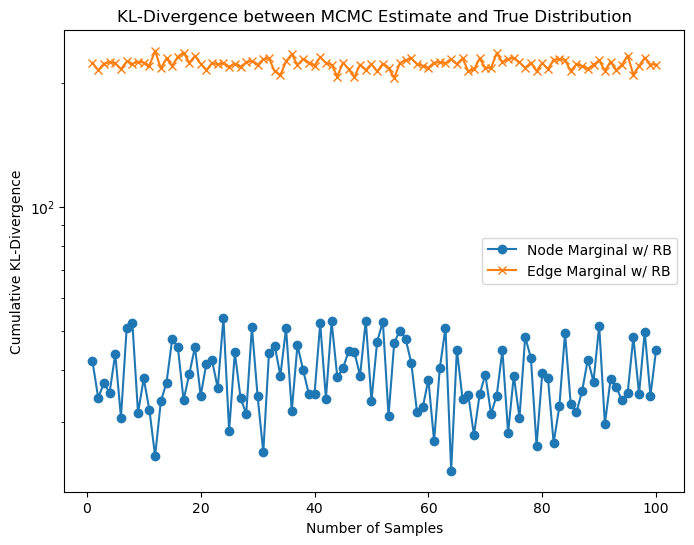

In [67]:
    
# Plot the KL-divergences
plt.figure(figsize=(8, 6))
plt.plot(range(1, S + 1), kl_node_rb, label='Node Marginal w/ RB', marker='o')
plt.plot(range(1, S + 1), kl_edge_rb, label='Edge Marginal w/ RB', marker='x')
plt.xlabel('Number of Samples')
plt.ylabel('Cumulative KL-Divergence')
plt.yscale('log')  # Use logarithmic scale for better visualization
plt.title('KL-Divergence between MCMC Estimate and True Distribution')
plt.legend()
plt.show()

The four curves you need according to the question are:

KL-divergence of node marginal with Rao-Blackwellization (which you have).

KL-divergence of edge marginal with Rao-Blackwellization (which you have).

KL-divergence of node marginal without Rao-Blackwellization.

KL-divergence of edge marginal without Rao-Blackwellization.

In [69]:
import numpy as np

def simple_mcmc(X, T, W, num_samples, num_classes):
    num_nodes = X.shape[0]
    y_samples = np.zeros((num_samples, num_nodes), dtype=int)
    
    # Initialize the sequence randomly for each sample
    for s in range(num_samples):
        y_samples[s] = np.random.choice(num_classes, num_nodes)
        
        # Perform MCMC sampling
        for _ in range(num_nodes):
            for k in range(num_nodes):
                y_samples[s, k] = sample_given_neighbors(k, T, W, y_samples[s], X)
    
    return y_samples

def calculate_marginals_from_samples(y_samples, num_classes):
    num_samples, num_nodes = y_samples.shape
    node_marginals = np.zeros((num_nodes, num_classes))
    edge_marginals = np.zeros((num_nodes - 1, num_classes, num_classes))
    
    # Calculate node marginals
    for k in range(num_nodes):
        for c in range(num_classes):
            node_marginals[k, c] = np.sum(y_samples[:, k] == c) / num_samples
    
    # Calculate edge marginals
    for k in range(1, num_nodes):
        for c1 in range(num_classes):
            for c2 in range(num_classes):
                edge_marginals[k-1, c1, c2] = np.sum((y_samples[:, k-1] == c1) & (y_samples[:, k] == c2)) / num_samples
    
    return node_marginals, edge_marginals


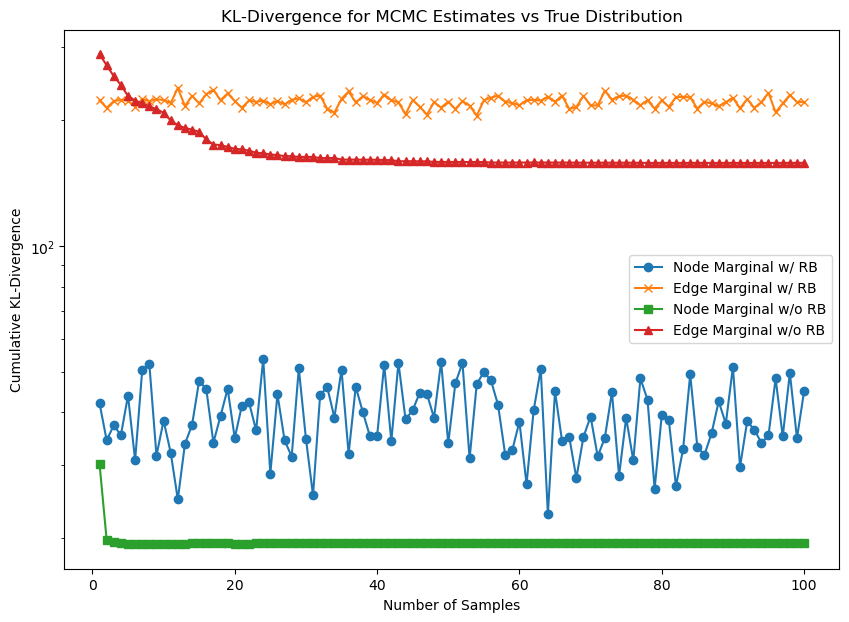

In [71]:
# Use the simple MCMC function to calculate the node and edge marginals
y_samples = simple_mcmc(X, T, W, S, num_classes)
node_marginals_simple, edge_marginals_simple = calculate_marginals_from_samples(y_samples, num_classes)

# Initialize lists to hold cumulative KL-divergences for simple MCMC
kl_node_simple = []
kl_edge_simple = []

# Reshape p_edge_true_mean to match the shape of edge_marginal_mean
p_edge_true_mean_reshaped = p_edge_true_mean.reshape((26, 26))

# Compute cumulative KL divergence for edge marginals without Rao-Blackwellization
for s in range(1, S + 1):
    # Calculate the mean of the estimates up to the current number of samples
    node_marginal_mean = node_marginals_simple[:s].mean(axis=0)
    edge_marginal_mean = edge_marginals_simple[:s].mean(axis=0)
    
    # Calculate KL divergence with reshaped p_edge_true_mean
    kl_node_simple.append(kl_divergence(p_node_true_mean, node_marginal_mean))
    kl_edge_simple.append(kl_divergence(p_edge_true_mean_reshaped, edge_marginal_mean))


# Plot the additional two curves on the same graph
plt.figure(figsize=(10, 7))
plt.plot(range(1, S + 1), kl_node_rb, label='Node Marginal w/ RB', marker='o')
plt.plot(range(1, S + 1), kl_edge_rb, label='Edge Marginal w/ RB', marker='x')
plt.plot(range(1, S + 1), kl_node_simple, label='Node Marginal w/o RB', marker='s')
plt.plot(range(1, S + 1), kl_edge_simple, label='Edge Marginal w/o RB', marker='^')
plt.xlabel('Number of Samples')
plt.ylabel('Cumulative KL-Divergence')
plt.yscale('log')  # Use logarithmic scale for better visualization
plt.title('KL-Divergence for MCMC Estimates vs True Distribution')
plt.legend()
plt.show()


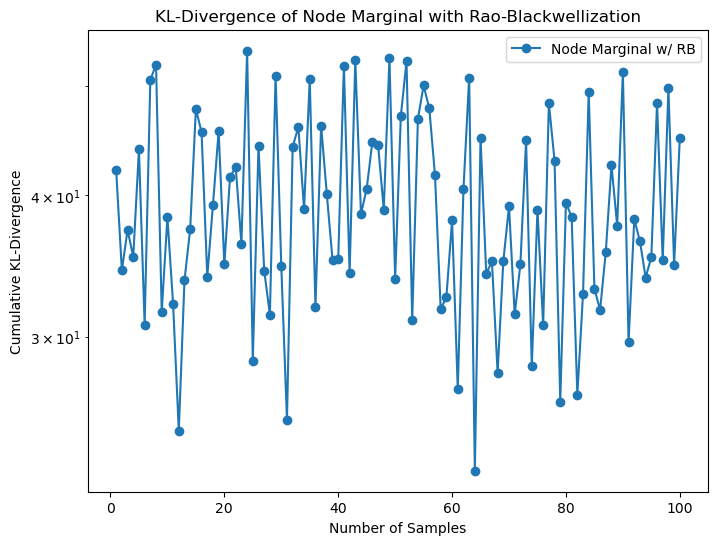

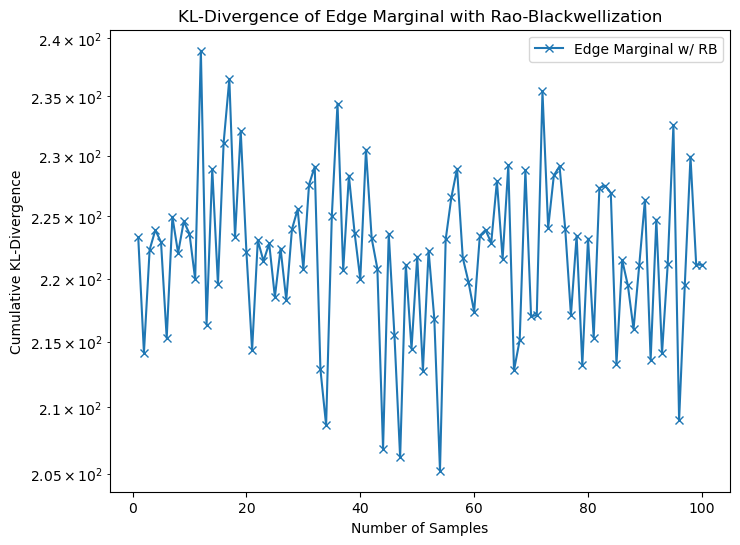

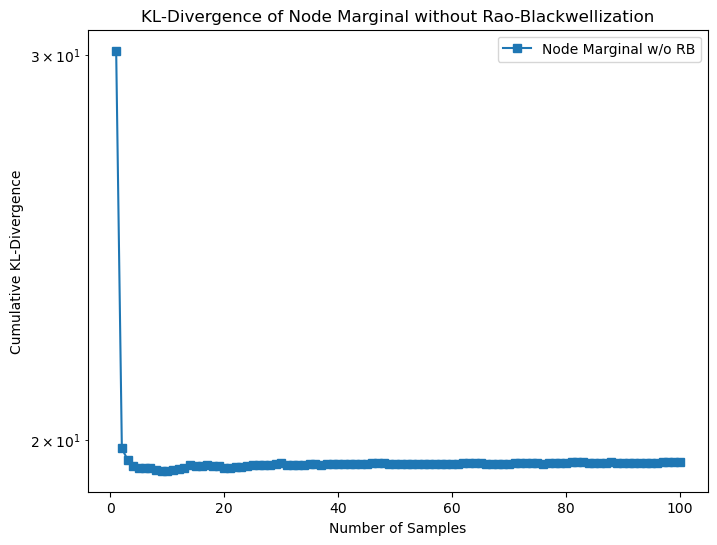

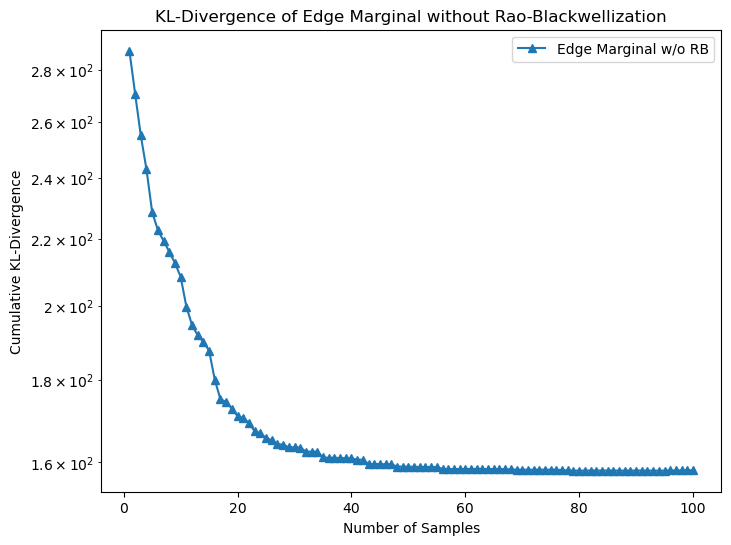

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the KL-divergences for node and edge marginals with Rao-Blackwellization
plt.figure(figsize=(8, 6))
plt.plot(range(1, S + 1), kl_node_rb, label='Node Marginal w/ RB', marker='o')
plt.xlabel('Number of Samples')
plt.ylabel('Cumulative KL-Divergence')
plt.yscale('log')  # Use logarithmic scale for better visualization
plt.title('KL-Divergence of Node Marginal with Rao-Blackwellization')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(range(1, S + 1), kl_edge_rb, label='Edge Marginal w/ RB', marker='x')
plt.xlabel('Number of Samples')
plt.ylabel('Cumulative KL-Divergence')
plt.yscale('log')  # Use logarithmic scale for better visualization
plt.title('KL-Divergence of Edge Marginal with Rao-Blackwellization')
plt.legend()
plt.show()

# Plot the KL-divergences for node and edge marginals without Rao-Blackwellization
plt.figure(figsize=(8, 6))
plt.plot(range(1, S + 1), kl_node_simple, label='Node Marginal w/o RB', marker='s')
plt.xlabel('Number of Samples')
plt.ylabel('Cumulative KL-Divergence')
plt.yscale('log')  # Use logarithmic scale for better visualization
plt.title('KL-Divergence of Node Marginal without Rao-Blackwellization')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(range(1, S + 1), kl_edge_simple, label='Edge Marginal w/o RB', marker='^')
plt.xlabel('Number of Samples')
plt.ylabel('Cumulative KL-Divergence')
plt.yscale('log')  # Use logarithmic scale for better visualization
plt.title('KL-Divergence of Edge Marginal without Rao-Blackwellization')
plt.legend()
plt.show()
